In [1]:
from htc_class import HolsteinTavisCummings
import numpy as np
from qutip import *
from qutip.core.gates import *
from numpy import array
from numpy import real
import matplotlib.pyplot as plt
pi = np.pi
hf_params = {
    'w_q1': 0.8365513706206968,         # Qubit 1 frequency (e.g., in GHz)
    'w_q2': 0.8365513706206968,         # Qubit 2 frequency
    'w_vib1': 0.018335911729858174,       # Vibrational mode 1 frequency
    'w_vib2': 0.018335911729858174,      # Vibrational mode 2 frequency
    'w_cav': 5 * np.pi,        # Cavity frequency
    'S_1': 1.0,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 1.0,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.026919208248238624,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.026919208248238624,    # Cavity coupling strength for qubit 2
    'N_vib': 1,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'qubit_1_dipole_moments' : 
    { 
        'mu_g': 0, 
        'mu_e': 0, 
        'mu_eg': 1
    },
    'qubit_2_dipole_moments' : 
    { 
        'mu_g': 0, 
        'mu_e': 0, 
        'mu_eg': 1.5
    }
}

# using the same paramters as the tutorial for now!
tutorial_params = {

    'w_q1': 3 * 2 * np.pi,         # Qubit 1 frequency (e.g., in GHz)
    'w_q2': 2 * 2 * np.pi,         # Qubit 2 frequency
    'w_vib1': 0.0, #18335911729858174,       # Vibrational mode 1 frequency
    'w_vib2': 0.0, #18335911729858174,      # Vibrational mode 2 frequency
    'w_cav': 5 * 2 * np.pi,        # Cavity frequency
    'S_1': 0,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 0,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.0,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.0,    # Cavity coupling strength for qubit 2
    'N_vib': 1,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'simple_g' : True,
    'sigma_z_Hq' : True, # formulate qubit Hamiltonians as -w / 2 * sigma_z
    'g1' : 0.01 * 2 * np.pi,
    'g2' : 0.0125 * 2 * np.pi
}


# Example parameters
system = HolsteinTavisCummings( tutorial_params )
g1 = system.g1
g2 = system.g2


tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*np.pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*np.pi)/(4 * g2)







In [2]:
system.build_hamiltonian()

# the following attributes store the different contributions to the Hamiltonian (all on the full Hilbert space)
### Bare Hamiltonians
# .H_q1 -> qubit 1 Hamiltonian
# .H_q2 -> qubit 2 Hamiltonian
# .H_qubit -> qubit 1 + qubit 2 Hamiltonian 
# .H_vib1 -> vibrational Hamiltonian for qubit 1
# .H_vib2 -> vibrational Hamiltonian for qubit 2
# .H_vibrational -> vibrational Hamiltonians for qubit 1 + qubit 2
# .H_cav -> cavity Hamiltonian

# Coupling Hamiltonians
# Note on qubit - cavity coupling - several flavors available:
#  a. Tavis-Cummings (parameterized by `g1` and `g2` or by `sqrt(w1/2) * lambda * mu1_{eg}` and  `sqrt(w2/2) * lambda * mu2_{eg}`  
#  b. Pauli-Fierz (sqrt(w1/2) * lambda * mu1, sqrt(w2/2) * lambda * mu2 using full operators)
#  c. If Pauli-Fierz, may also include dipole self energy if requested

# .H_q1_cav -> coupling between qubit 1 and cavity
# .H_q2_cav -> coupling between qubit 2 and cavity
# .H_qubit_cavity_coupling -> coupling between qubits 1 and 2 and cavity

# .H_q1_vib1 -> vibronic coupling for qubit 1
# .H_q2_vib2 -> vibronic coupling for qubit 2
# .H_qubit_vibrational_coupling -> vibronic couplings for qubit 1 and qubit 2

Using Tavis-Cummings coupling
Using simple g coupling
g1: 0.06283185307179587, g2: 0.07853981633974483


In [3]:
wc = system.w_cav
w1 = system.w_q1
w2 = system.w_q2
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t.
    """
    return w1 + (w2 - w1) * (t > t0)

def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)




In [4]:
# Qutip code looked like the following:
# H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

# we will adapt to our class as follows:
H_t = [[system.H_cav, wc_t], [system.H_q1, w1_t], [system.H_q2, w2_t], system.H_qubit_cavity_coupling]

In [5]:
# initial state: start with one of the qubits in its excited state - note we need to reorder basis
# the qutip had cavity basis first, we have it last 
# qutip tutorial: psi0 = tensor(basis(N,0),basis(2,1),basis(2,0)) 
# equivalent in our basis: psi0 = tensor(basis(2,1), basis(2,0), basis(N,0))
psi0 = tensor(basis(2,1), basis(2,0), basis(1,0), basis(1,0), basis(system.N_cav,0))


In [6]:
res = mesolve(H_t, psi0, tlist, [], [])

/Users/jfoley19/miniforge3/envs/qutip/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [8]:
# these operators need to be defined for the plot below

# cavity operators on the full Hilbert space
a = tensor( qeye(2), qeye(2), qeye(system.N_vib), qeye(system.N_vib), destroy(system.N_cav) )
n = a.dag() * a

# operators for qubit 1
sm1 = tensor( destroy(2), qeye(2), qeye(system.N_vib), qeye(system.N_vib), qeye(system.N_cav) ) 
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = sm1 = tensor(qeye(2) , destroy(2), qeye(system.N_vib), qeye(system.N_vib), qeye(system.N_cav) ) 
sz2 = tensor(qeye(2), sigmaz(), qeye(system.N_vib), qeye(system.N_vib), qeye(system.N_cav) )
n2 = sm2.dag() * sm2

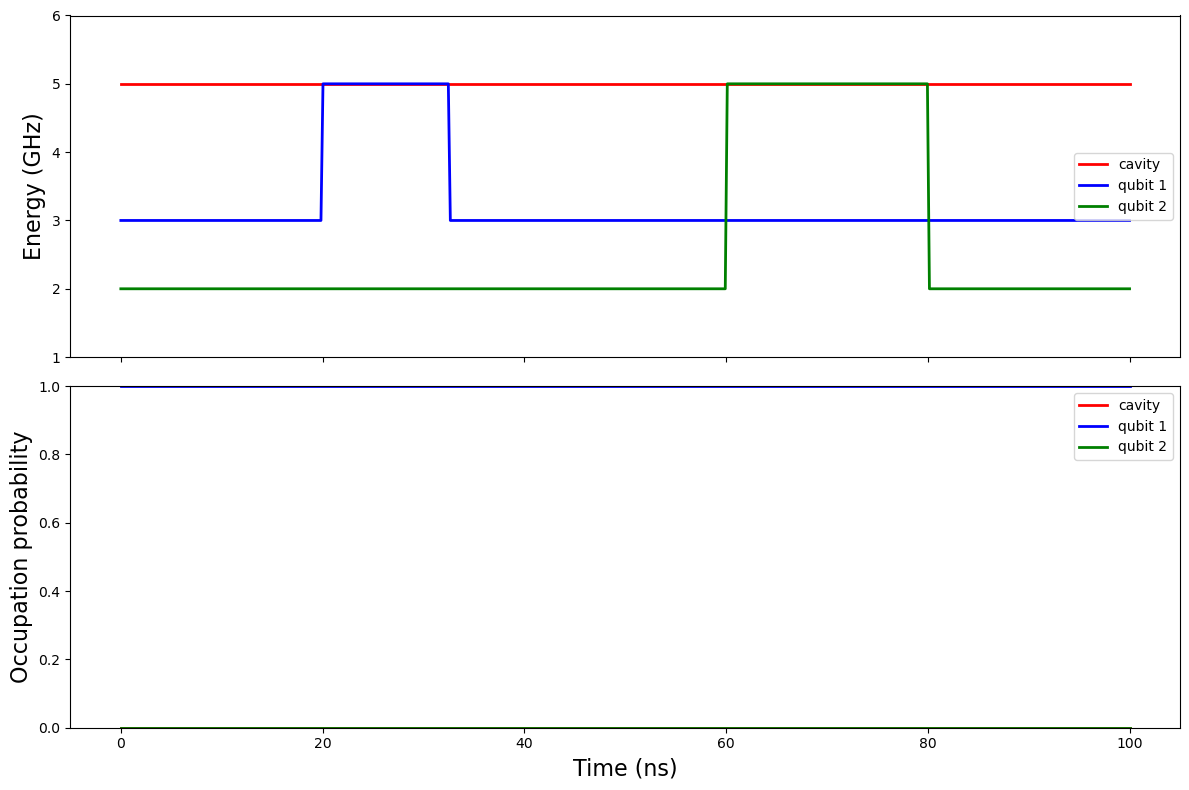

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [12]:
rho_final = res.states[-1]
rho_final

Quantum object: dims=[[2, 2, 1, 1, 2], [1, 1, 1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 3.91708416e-04-3.03572826e-05j]
 [ 2.12741588e-07-3.58600496e-07j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-8.89791282e-01-4.56367527e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]]

In [11]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [0,1])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.54357048e-07+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.73853299e-13+0.00000000e+00j
  -2.56419894e-08+4.16167947e-07j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.56419894e-08-4.16167947e-07j
   9.99999846e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]]